# Chandu Bibliographic Paper 

Past Work: file: [2025-07-18_scopus_search7a_anlaysis.ipynb](2025-07-18_scopus_search7a_anlaysis.ipynb).  
1. Sep-2024 -> Jul-2025. Topic: High Performance Teams.  
2. Methodology: search for the topic in [Scopus](https://idp.alliance.edu.in/). Download the data (csv file). Open the file in [VOSViewer](https://www.vosviewer.com/). Analyze the data. 
3. Why this Jupyter code: some anlaysis is not feasible in VOSViewer. Hence this this Jupyter (python) code. 
4. Ref: [Scraptchpad](D:/Chandu/Learning/Prj_NLP_2023/Scratchpad.ipynb) 

Current Work (Oct-2025): [2025-07-18p_scopus_search7a_anlaysis2.ipynb](2025-07-18p_scopus_search7a_anlaysis2.ipynb) <-- current file.  
1. [SciMAT](https://dasci.es/en/software/scimat-2/) and [Download](https://sci2s.ugr.es/scimat/) shows Strategic Diagrams (Centrality vs. Density). However, I am not able to get them (I could get either one but not both). So, decided to write my own code for it. 
2. Definitions: Keywords Clusters: Density is the number of links WITHIN a cluster, whereas Centrality is BETWEEN clusters. 
3. So, write code to:
    1. Build a graph/matrix of keywords co-occurrence (links)   
    2. Map keywords to clusters ... use the clusters from GenAI, file: [2025-07-29a_4.7_Keywords_Clusters_k10.xlsx](2025-07-29a_4.7_Keywords_Clusters_k10.xlsx)   
    3. Compute each cluster's Centrality and Density    
    4. Show them in a bubble chart ... bubble size depends on: #docs, or sum(citations), or avg(citations)   

## 0. Setup  

In [7]:
#0. Imports 
#Ref: [Scraptchpad](D:\Chandu\Learning\Prj_NLP_2023\Scratchpad.ipynb) 

# reqiuired for my utilities  
import os, time, sys        
from datetime import datetime       
import logging       
import pprint       
import math     
import re       

# required for my functionality code 
import pandas as pd   
import numpy as np    
import matplotlib.pyplot as plt     
import seaborn as sns  
from itertools import combinations 
from collections import Counter  
import itertools  
import networkx as nx  

# setup logging  
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO)    
logging.StreamHandler(sys.stdout)    

print('imports are done')     
print(f'{logging.root.level = }')    
logging.info('imports are done-2')    
logging.info('Beware not to mix logging and print - all the logging may be shown first, and then the print statements')   

start_time = datetime.now()   

print('****** Started at = ', start_time)   
print('****** Last ran at = ', datetime.now())   

2025-10-19 19:26:08,913 - root - INFO - imports are done-2
2025-10-19 19:26:08,915 - root - INFO - Beware not to mix logging and print - all the logging may be shown first, and then the print statements


imports are done
logging.root.level = 20
****** Started at =  2025-10-19 19:26:08.917254
****** Last ran at =  2025-10-19 19:26:08.917254


In [8]:
# Skip - Custom Magic Functions   
# 1. StackOverflow (Freeze nbextension):  https://stackoverflow.com/questions/19309287/how-to-intermittently-skip-certain-cells-when-running-ipython-notebook    <--- not useful     

# 2. Kioku-Space:  https://kioku-space.com/en/jupyter-skip-execution/      
# 2.1. How to Skip a Cell Execution
# 2.1-a. First, create a skip magic command that does nothing.  
from IPython.core.magic import register_cell_magic    
@register_cell_magic   
def skip(line, cell):    
    print("This cell will NOT be run because it used %%skip custom magic function")    
    return    
print('Step 2.1. done')    
# 2.1-b To skip a cell, simply add %%skip at the top line of the cell.   
# %%skip      # this errs because this is not the top line of the cell    

# 2.2. How to Conditionally Skip a Cell Execution  
# 2.2-a. Create a skip_if magic command.  
from IPython.core.magic import register_cell_magic    
from IPython import get_ipython    
@register_cell_magic    
def skip_if(line, cell):  
    if eval(line):    
        print("This cell will NOT be run because it used %%skip_if <condition> custom magic function")    
        return     
    get_ipython().run_cell(cell)      
# 2.2-b. To use it, add %%skip_if <condition> at the top of the cell.    
# %%skip_if True      # this errs because this is not the top line of the cell    

print('****** Last ran at = ', datetime.now())   

Step 2.1. done
****** Last ran at =  2025-10-19 19:26:08.937687


In [9]:
%%skip   # Jul-2024   
a = 1    
print(f'a = {a}')  # this will not be printed because this cell is skipped from running    
print('****** Last ran at = ', datetime.now())   

This cell will NOT be run because it used %%skip custom magic function


In [10]:
%%skip_if True    # Jul-2024    
a = 1     
print(f'a = {a}')  # this will not be printed because this cell is skipped from running    
print('****** Last ran at = ', datetime.now())    

This cell will NOT be run because it used %%skip_if <condition> custom magic function


## 0. Data Inputs  

1. Oct-2025: Strategic Diagrams (Centrality vs. Density).    
2. The minimal data fields needed are: doc_id, citations, keywords.    
3. We copied the Scopus search results: [2025-07-29_scopus_search8_194b.csv](2025-07-29_scopus_search8_194b.csv) into a new csv file: [2025-07-29_scopus_search8_194b_strategic.csv](2025-07-29_scopus_search8_194b_strategic.csv).    
4. We will use (later) the GenAI Clusters: [2025-07-29a_4.7_Keywords_Clusters_k10.xlsx](2025-07-29a_4.7_Keywords_Clusters_k10.xlsx).    

## 1. Read, Reorg Data  

1. Oct-2025: Goal: convert from (DocID, Keywords) -> (Keyword, DocIDs) ... `1:n` -> `n:1`  
2. Read from the file: [2025-07-29_scopus_search8_194b_strategic.csv](2025-07-29_scopus_search8_194b_strategic.csv) which is a stripped-down copy of the Scopus export file: [2025-07-29_scopus_search8_194b.csv](2025-07-29_scopus_search8_194b.csv)   
3. Save exploded data (DocID, Keyword) to file: [2025-07-29_scopus_search8_194b_strategic_out.csv](2025-07-29_scopus_search8_194b_strategic_out.csv)  
4. Save result data (Keyword, DocIDs)  to file: [2025-07-29_scopus_search8_194b_strategic_out2.csv](2025-07-29_scopus_search8_194b_strategic_out2.csv)  

| Step | Action | File |
|----------|----------|----------|
| 1 | Read from file (`DocID`, `Keywords`) (1:n), `df`  | [2025-07-29_scopus_search8_194b_strategic.csv](2025-07-29_scopus_search8_194b_strategic.csv) |
| 2 | Save exploded data (`DocID`, `Keyword`) (1:1), `df2` | [2025-07-29_scopus_search8_194b_strategic_out.csv](2025-07-29_scopus_search8_194b_strategic_out.csv)  |  
| 3 | Save result data (`DocIDs`, `Keyword`) (n:1), `df3` | [2025-07-29_scopus_search8_194b_strategic_out2.csv](2025-07-29_scopus_search8_194b_strategic_out2.csv)  | 

Notice the <font style="color:yellow">singular</font> and <font style="color:yellow">plural</font> transormations.   


In [11]:
#1. read data (df) 

# imports are done upfront above  
# import pandas as pd  
print('****** Last ran at = ', datetime.now())   

# -------------------------------
# Step 1: Read the data from the input CSV file
input_file = "2025-07-29_scopus_search8_194b_strategic.csv"    # Doc ID (not Sl), 
df = pd.read_csv(input_file)   
print(f'Just read: {df.columns = }')  # 'Sl', 'Title', 'Cited by', 'Author Keywords', 'Index Keywords    

# Step 1.1 create Keywords column from Author Keywords and Index Keywords   
# df['Keywords'] = df['Author Keywords'] + ';' + df['Index Keywords']   # copy from two columns  
df['Keywords'] = df['Author Keywords']  # copy from a single column  
print(f'Keywords column added: {df.columns = }')  # 'Sl', 'Title', 'Cited

# Step 1.1. rename columns for ease of use  
df.rename(columns={'Sl': 'DocID', 'Cited by': 'Citations'}, inplace=True)   
print(f'Renamed columns: {df.columns = }')  # 'DocId', 'Title', 'Citations', 'Keywords', 'Index Keywords'    
df = df.drop(columns=['Author Keywords', 'Index Keywords'])   # drop unneeded columns  
print(f'Dropped columns: {df.columns = }')  # 'DocId', 'Title', 'Citations', 'Keywords', 

# Step 1.2. in case we weant to Index Keywords too, then merge the two columns  
# df['Keywords'] = df['Author Keywords'] + ';' + df['Index Keywords']   
# print(df.columns)  

# Step 1.3: clean up the missing values in Keywords column  
df['Keywords'] = df['Keywords'].fillna('No Keyword')   # Check: Doc 22 has no keywords    

print(f'{df.head(5) =}')  
print('****** Last ran at = ', datetime.now())    

****** Last ran at =  2025-10-19 19:26:08.976199
Just read: df.columns = Index(['Sl', 'Title', 'Cited by', 'Author Keywords', 'Index Keywords'], dtype='object')
Keywords column added: df.columns = Index(['Sl', 'Title', 'Cited by', 'Author Keywords', 'Index Keywords',
       'Keywords'],
      dtype='object')
Renamed columns: df.columns = Index(['DocID', 'Title', 'Citations', 'Author Keywords', 'Index Keywords',
       'Keywords'],
      dtype='object')
Dropped columns: df.columns = Index(['DocID', 'Title', 'Citations', 'Keywords'], dtype='object')
df.head(5) =   DocID                                              Title  Citations  \
0      1  The influence of empowering team leadership on...          5   
1      2  The impact of developmental job experience on ...          2   
2      3  Team conflict dynamics: Implications of a dyad...         71   
3      4  Mediating effects of person-environment fit on...         18   
4      5  Ambidextrous culture, innovation strategy and ...     

In [12]:
#2 keywords: string -> list  (df)  
print('****** Last ran at = ', datetime.now())  

# Step 2: Split 'Keywords' into lists and then explode them   

# Step 2.1. Convert 'Keywords' from string to list   
df['Keywords'] = df['Keywords'].str.split(';') # make a list   

# Step 2.2. Trim whitespace from each keyword in the list   
df['Keywords'] = df['Keywords'].apply(lambda x: [item.strip() for item in x])   

print(f'Keywords converted to List: df.head(5) = \n{df.head(5)}')  

****** Last ran at =  2025-10-19 19:26:09.002670
Keywords converted to List: df.head(5) = 
   DocID                                              Title  Citations  \
0      1  The influence of empowering team leadership on...          5   
1      2  The impact of developmental job experience on ...          2   
2      3  Team conflict dynamics: Implications of a dyad...         71   
3      4  Mediating effects of person-environment fit on...         18   
4      5  Ambidextrous culture, innovation strategy and ...          8   

                                            Keywords  
0  [empowering team leadership, high-tech enterpr...  
1  [developmental job experience, job performance...  
2                      [Conflict, Dyad, Group, Team]  
3  [Firm performance, High performance human reso...  
4  [Ambidextrous culture, Innovative strategies, ...  


In [13]:
#3. explode keywords (df2, out2)   

# Step 3.1: Explode the 'Keywords' column to have one keyword per row   
df2 = df.explode('Keywords')  
df2.rename(columns={'Keywords': 'Keyword'}, inplace=True)   
df2['Keyword'] = df2['Keyword'].str.strip()  # trim the column values  
print(f'Keywords exploded: {df2.head(25) = }')  

# save 
# Step 3.2: Write the result to a CSV file  
output2_file = input_file[0:-4]  +  '_out2' + '.csv'  
df2.to_csv(output2_file, index=False)   
print("Done! Output-2 written to", output2_file)   

print('****** Last ran at = ', datetime.now())  

Keywords exploded: df2.head(25) =    DocID                                              Title  Citations  \
0      1  The influence of empowering team leadership on...          5   
0      1  The influence of empowering team leadership on...          5   
0      1  The influence of empowering team leadership on...          5   
0      1  The influence of empowering team leadership on...          5   
0      1  The influence of empowering team leadership on...          5   
1      2  The impact of developmental job experience on ...          2   
1      2  The impact of developmental job experience on ...          2   
1      2  The impact of developmental job experience on ...          2   
1      2  The impact of developmental job experience on ...          2   
2      3  Team conflict dynamics: Implications of a dyad...         71   
2      3  Team conflict dynamics: Implications of a dyad...         71   
2      3  Team conflict dynamics: Implications of a dyad...         71   
2   

In [14]:
#4. keyword -> docs (n:1) (df3, out3)   

# Step 4: Group by 'Keyword' and aggregate 'DocID'
df3 = df2.groupby('Keyword')['DocID'].apply(lambda x: ', '.join(map(str, sorted(x)))).reset_index()  
df3.rename(columns={'DocID': 'DocIDs'}, inplace=True)    # rename for better clarity  
print(f'Keyword vs. DocIDs: {df3.head(5) = }')  

# save  
output3_file = input_file[0:-4]  +  '_out3' + '.csv'  
df3.to_csv(output3_file, index=False)  
print("Done! Output-3 written to", output3_file)     

print('****** Last ran at = ', datetime.now())  

Keyword vs. DocIDs: df3.head(5) =                      Keyword DocIDs
0             (In)congruence     78
1        360-degree feedback    129
2  Activated team faultlines     38
3      Adaptation and change     24
4    Affirmative action bias    175
Done! Output-3 written to 2025-07-29_scopus_search8_194b_strategic_out3.csv
****** Last ran at =  2025-10-19 19:26:09.073292


## 2. Co-Occurrence Matrix  

1. We do not need df2, df3 but need only df1 in the below code? 

| Step | Action | File |
|----------|----------|----------|
| x | `df` -> keywords -> `Co-Occurrence Matrix`  | no file | 

In [15]:
#1. review data  

print(df['Keywords'][0])  # Note that Keywords is now a list, not string  
# If any value was null, it should have been replaced by "No Keyword" string (list), so look for that value  

print('****** Last ran at = ', datetime.now())  

['empowering team leadership', 'high-tech enterprises', 'innovation climate based on advantages', 'innovation passion', 'innovation self-efficacy']
****** Last ran at =  2025-10-19 19:26:09.089809


In [ ]:
#2. co-occurrence matrix calculation  

# All unique keywords
# keywords = sorted(set(itertools.chain.from_iterable(df['Keywords'])))  
keywords = list(itertools.chain.from_iterable(df['Keywords']))   
keywords = [item.strip() for item in keywords]   
keywords = sorted(set(keywords))  

# Initialize co-occurrence matrix  
cooc_matrix = pd.DataFrame(  
    data=0, index=keywords, columns=keywords, dtype=int  
) 

# Count co-occurrences  
for kw_list in df['Keywords']:  
    for kw1, kw2 in itertools.combinations(sorted(kw_list), 2):  
        cooc_matrix.loc[kw1, kw2] += 1  
        cooc_matrix.loc[kw2, kw1] += 1      # Because co-occurrence is symmetric  
    # we are not intereted in diagonal counts here, hence no need to set diagonal=1  

print(f'{len(keywords) = }')  
print(f'keywords = \n{keywords}')         # 700 keywords?   
print("-" * 25)    
print(f'cooc_matrix = \n{cooc_matrix}')      # 700x700 matrix for 700 keywords   

print('****** Last ran at = ', datetime.now())   

len(keywords) = 676
keywords = 
['(In)congruence', '360-degree feedback', 'Activated team faultlines', 'Adaptation and change', 'Affirmative action bias', 'Age diversity', 'Agency theory', 'Ambidextrous culture', 'Appropriability strategy', 'Attribution principles', 'Authentic leadership', 'Awards', 'Banking and Financial Institutions (BFIs)', 'Behavior', 'Behavioral interdependence', 'Behavioral operations', 'Bottom-line mentality', 'Brokerage', 'CEO compensation', 'CEO-TMT interplay', 'CEOs', 'CMO', 'Causal attribution', 'Causal attributions', 'Centrality', 'Change', 'Change management', 'Charisma', 'Charities', 'Chief executive officer', 'Chief executives', 'China', 'China-based American companies', 'Chinese companies', 'Chinese employees', 'Climate strength', 'Coercive', 'Cognitive diversity', 'Cognitive style', 'Cohesion', 'Collective emotional intelligence', 'Collective learning orientation', 'Collective performance orientation', 'Collectivist culture', 'Commitment', 'Compensatio

In [39]:
mykw = list(itertools.chain.from_iterable(df['Keywords']))    
print(len(mykw))    
mykw = [item.strip() for item in mykw]     
print(len(mykw))     
mykw = sorted(set(mykw)) 
print(len(mykw))     

877
877
676


In [17]:
# save 
output4_cooc_mat_file = input_file[0:-4]  +  '_out4a_km' + '.csv'  
cooc_matrix.to_csv(output4_cooc_mat_file, index=True)  
print("Done! Output-4 cooc_matrix written to", output4_cooc_mat_file)   

Done! Output-4 cooc_matrix written to 2025-07-29_scopus_search8_194b_strategic_out4a_km.csv


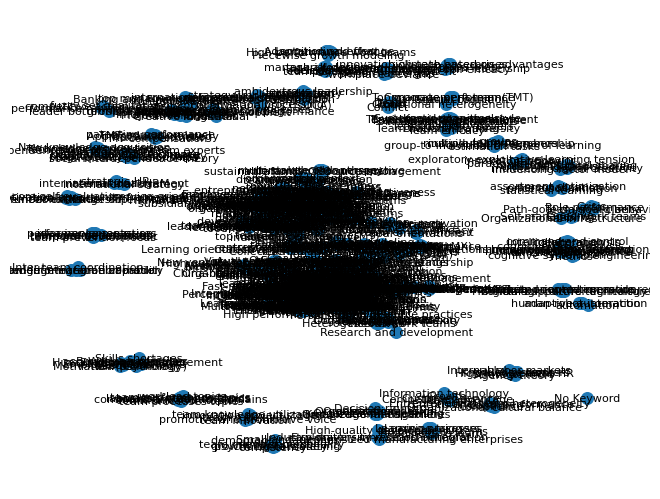

****** Last ran at =  2025-10-19 19:26:15.484379


In [18]:
#3. co-occurrence matrix visualization   
# import networkx as nx  
# import matplotlib.pyplot as plt  

# Build graph from matrix
G = nx.from_pandas_adjacency(cooc_matrix)  
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=70, font_size=8)  # 
# Optionally, add edge labels (weights)  
labels = nx.get_edge_attributes(G,'weight')  
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)  
plt.show()  

print('****** Last ran at = ', datetime.now())   

## 3. Clusters 

1. Oct-2025: we need a dictionary (keywords to clusters), e.g.: `kw2cls = {'kw1': 'c1',  'kw2': 'c1', ...}`  
2. The clusters here are the GenAI Clusters, see: [2025-07-29a_4.7_Keywords_Clusters_k10.xlsx](2025-07-29a_4.7_Keywords_Clusters_k10.xlsx)   

| Step | Action | File |
|----------|----------|----------|
| 4 | Read from file (`Cluster`, `Keywords`) (1:n), `df4` | [2025-07-29a_4.7_Keywords_Clusters_k10.xlsx](2025-07-29a_4.7_Keywords_Clusters_k10.xlsx) |   
| 4b | `df4` and `keywords cooc_matrix` -> Cluster Matrix | save to: [2025-07-29_scopus_search8_194b_strategic_out4_cm.csv](2025-07-29_scopus_search8_194b_strategic_out4_cm.csv) |   

In [19]:
#1. read data 

# input file, dataframe   
input4_file = "2025-07-29a_4.7_Keywords_Clusters_k10.xlsx"    # Sl, x, y, df_keywords, cluster2, cluster_name    
df4 = pd.read_excel(input4_file)   

print(f'Just read: df4.columns = \n\t{df4.columns}\n')  # Sl, x, y, df_keywords, cluster2, cluster_name     
print(f'df4.head(5) = \n{df4.head(5)}\n')  

print('****** Last ran at = ', datetime.now())   
print(f'\n-------------------------\n')


# clean data (drop, rename)   
df4 = df4.drop(columns=['x', 'y'])   
df4.rename(columns={'Sl': 'KWID', 'df_keywords': 'Keyword', 'cluster2': 'ClusterID', 'cluster_name': 'Cluster' }, inplace=True)   

print(f'After cleanup: df4.columns = \n\t{df4.columns}\n')  #  KWID, Keyword, ClusterID, Cluster   
print(f'df4.head(5) = \n{df4.head(5)}\n')  

print('****** Last ran at = ', datetime.now())   

Just read: df4.columns = 
	Index(['Sl', 'x', 'y', 'df_keywords', 'cluster2', 'cluster_name'], dtype='object')

df4.head(5) = 
   Sl         x         y                df_keywords  cluster2  \
0   0  7.038094  5.864252             (In)congruence         3   
1   1  6.231300  5.267730        360-degree feedback         3   
2   2  9.058375  5.556919  Activated team faultlines         4   
3   3  4.468338  4.146387      Adaptation and change         3   
4   4  5.805002  3.957499    Affirmative action bias         7   

                               cluster_name  
0  Aligning Diversity, Feedback, and Change  
1  Aligning Diversity, Feedback, and Change  
2        Diverse Teams, Adaptive Strategies  
3  Aligning Diversity, Feedback, and Change  
4             Navigating Workplace Tensions  

****** Last ran at =  2025-10-19 19:26:15.975885

-------------------------

After cleanup: df4.columns = 
	Index(['KWID', 'Keyword', 'ClusterID', 'Cluster'], dtype='object')

df4.head(5) = 
   KWID  

In [20]:
#2. dictionary  

keyword2cluster = df4.groupby('Keyword')['Cluster'].apply(list).to_dict()   

print(keyword2cluster)  
print('****** Last ran at = ', datetime.now())    

{'(In)congruence': ['Aligning Diversity, Feedback, and Change'], '360-degree feedback': ['Aligning Diversity, Feedback, and Change'], 'Activated team faultlines': ['Diverse Teams, Adaptive Strategies'], 'Adaptation and change': ['Aligning Diversity, Feedback, and Change'], 'Affirmative action bias': ['Navigating Workplace Tensions'], 'Age diversity': ['Aligning Diversity, Feedback, and Change'], 'Agency theory': ['Knowledge Flow and Learning Dynamics'], 'Ambidextrous culture': ['Aligning Diversity, Feedback, and Change'], 'Appropriability strategy': ['Aligning Diversity, Feedback, and Change'], 'Attribution principles': ['Knowledge Flow and Learning Dynamics'], 'Authentic leadership': ['Aligning Diversity, Feedback, and Change'], 'Awards': ['Incentives Drive Behavioral Change'], 'Banking and Financial Institutions (BFIs)': ['Executive Pay and Firm Productivity'], 'Behavior': ['Incentives Drive Behavioral Change'], 'Behavioral interdependence': ['Aligning Diversity, Feedback, and Change

In [21]:
#3.1. cluster names list     
print('****** Last ran at = ', datetime.now())    

cluster_names = df4["Cluster"].unique().tolist()     
print(f'cluster_names = \n{cluster_names}\n')    
print(f'{len(cluster_names) = } \n')    

cluster_matrix = pd.DataFrame(   
    data=0, index=cluster_names, columns=cluster_names, dtype=int   )  
print(f'{cluster_matrix.shape = }\n')   

print('****** Last ran at = ', datetime.now())    

****** Last ran at =  2025-10-19 19:26:16.020675
cluster_names = 
['Aligning Diversity, Feedback, and Change', 'Diverse Teams, Adaptive Strategies', 'Navigating Workplace Tensions', 'Knowledge Flow and Learning Dynamics', 'Incentives Drive Behavioral Change', 'Executive Pay and Firm Productivity', 'Executive Leadership Dynamics', 'Achieving Unified Outcomes', 'Creative Exploration in High-Tech Ventures', 'Uniting for Success']

len(cluster_names) = 10 

cluster_matrix.shape = (10, 10)

****** Last ran at =  2025-10-19 19:26:16.023468


In [22]:
#3.2. reduce co-occurrence matrix from keywords to clusters (takes >10 min)   
print('****** Last ran at = ', datetime.now())    

# Sum up co-occurrences:    
i_cntr = 0  
for i in cooc_matrix.index:   
    for j in cooc_matrix.columns:   
        ci = keyword2cluster.get(i)   
        cj = keyword2cluster.get(j)   
        if ci and cj:   
            cluster_matrix.loc[ci, cj] += cooc_matrix.loc[i, j]    
    print(f'Done for {i_cntr = }, {i = } at {datetime.now()}')    
    i_cntr+=1   

print(f'{cluster_matrix.shape = }\n')   
print(cluster_matrix)  # 10x10 matrix?  

print('****** Last ran at = ', datetime.now())    

****** Last ran at =  2025-10-19 19:26:16.040640
Done for i_cntr = 0, i = '(In)congruence' at 2025-10-19 19:26:16.763373
Done for i_cntr = 1, i = '360-degree feedback' at 2025-10-19 19:26:17.499373
Done for i_cntr = 2, i = 'Activated team faultlines' at 2025-10-19 19:26:18.276435
Done for i_cntr = 3, i = 'Adaptation and change' at 2025-10-19 19:26:19.015121
Done for i_cntr = 4, i = 'Affirmative action bias' at 2025-10-19 19:26:19.822802
Done for i_cntr = 5, i = 'Age diversity' at 2025-10-19 19:26:20.568449
Done for i_cntr = 6, i = 'Agency theory' at 2025-10-19 19:26:21.310619
Done for i_cntr = 7, i = 'Ambidextrous culture' at 2025-10-19 19:26:22.113867
Done for i_cntr = 8, i = 'Appropriability strategy' at 2025-10-19 19:26:22.882091
Done for i_cntr = 9, i = 'Attribution principles' at 2025-10-19 19:26:23.697455
Done for i_cntr = 10, i = 'Authentic leadership' at 2025-10-19 19:26:24.444172
Done for i_cntr = 11, i = 'Awards' at 2025-10-19 19:26:25.231105
Done for i_cntr = 12, i = 'Bankin

In [23]:
# save    

output_cluster_matrix_file = input_file[0:-4]  +  '_out4b_cm' + '.csv'   
cluster_matrix.to_csv(output_cluster_matrix_file, index=True)   
print("Done! Output-4 Cluster Matrix written to: ", output_cluster_matrix_file)    

print('****** Last ran at = ', datetime.now())    

Done! Output-4 Cluster Matrix written to:  2025-07-29_scopus_search8_194b_strategic_out4b_cm.csv
****** Last ran at =  2025-10-19 19:34:57.351685


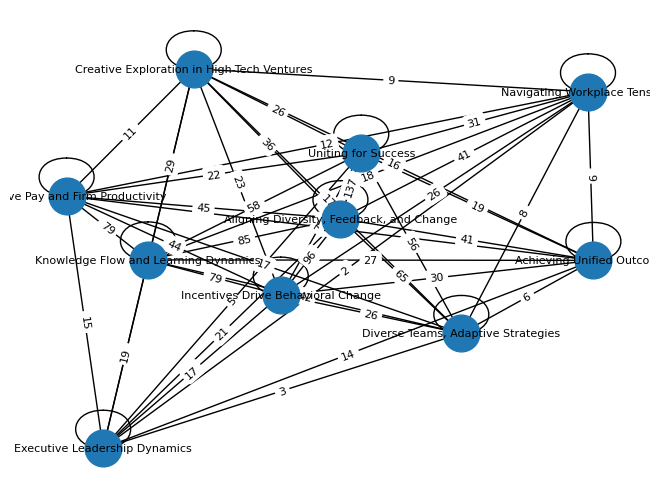

****** Last ran at =  2025-10-19 19:34:57.644385


In [24]:
#4. visualization   
# import networkx as nx  
# import matplotlib.pyplot as plt   

# Build graph from matrix
G = nx.from_pandas_adjacency(cluster_matrix)  
pos = nx.spring_layout(G)  
nx.draw(G, pos, with_labels=True, node_size=700, font_size=8)  
# Optionally, add edge labels (weights)  
labels = nx.get_edge_attributes(G,'weight')  
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=8)    
plt.show()   

print('****** Last ran at = ', datetime.now())    

## 4. Strategic Diagram (Centrality vs. Density)    

1. From the above `cluster_names` and `cluster_matrix`, we should compute the Centrality and Density. 

| Step | Action | File |
|----------|----------|----------|
| 5 | Create `df5` (`Cluster`, `Density`, `Centrality`) from `Cluster Matrix` | no file |   
| 6 | Create `df6` (`BubbliSize1,2,3`) from `df3` and `df4` | feeds to `df5[BubbleSize]` for visualization |  

df.columns = Index(['DocID', 'Title', 'Citations', 'Keywords'], dtype='object') 
	<-- this is an input data
df2.columns = Index(['DocID', 'Title', 'Citations', 'Keyword'], dtype='object') 
	<-- has exploded Keywords
df3.columns = Index(['Keyword', 'DocIDs'], dtype='object') 
	<-- this is an input data
df4.columns = Index(['KWID', 'Keyword', 'ClusterID', 'Cluster'], dtype='object')
df5.columns = Index(['Cluster', 'Density', 'Centrality', 'BubbleSize'], dtype='object') 
	<-- bubble size is a normalized one from df6
df6.columns = Index(['Cluster', 'DocIDs', 'BubbleSize1', 'BubbleSize2', 'BubbleSize3'], dtype='object')
****** Last ran at =  2025-10-19 15:51:53.289731

In [25]:
#1. centrality vs. density  
# import numpy as np  
# import pandas as pd  

# Define a function to compute density and centrality   
def compute_density_centrality(matrix, cluster_labels=None):  
    """  
    Compute density (diagonal) and centrality (sum of off-diagonal elements) for each cluster.  
  
    Args:  
        matrix (np.ndarray or pd.DataFrame): Square co-occurrence matrix.  
        cluster_labels (list, optional): List of labels for clusters. If None, use default indices.  
  
    Returns:  
        pd.DataFrame: DataFrame with cluster, density, and centrality.   
    """  
    # Convert to numpy array if matrix is a DataFrame  
    if isinstance(matrix, pd.DataFrame):  
        values = matrix.values  
        if cluster_labels is None:  
            cluster_labels = matrix.index.tolist()  
    else:  
        values = np.array(matrix)  
        if cluster_labels is None:  
            cluster_labels = list(range(values.shape[0]))  

    densities = np.diag(values)  
    centralities = []  
    for i in range(values.shape[0]):  
        centrality = np.sum(values[i, :]) - values[i, i]  
        centralities.append(centrality)  

    result = pd.DataFrame({  
        'Cluster': cluster_labels,  
        'Density': densities,  
        'Centrality': centralities  
    })

    return result

# Example usage:
# If you have a DataFrame:
# clusters = ['A', 'B', 'C']
# matrix = pd.DataFrame([[5, 1, 2], [1, 6, 0], [2, 0, 4]], index=clusters, columns=clusters)
# result = compute_density_centrality(matrix)
# print(result)   

# Call the function with your cluster_matrix  
df5 = compute_density_centrality(cluster_matrix)   
print(f'Centrality vs. Density, df5 = \n{df5}')   

# Save 
output5_file = input_file[0:-4]  +  '_out5_dc' + '.csv'   
df5.to_csv(output5_file, index=False)   
print("Done! Output-5 (Density, Centrality) written to: ", output5_file)    

print('****** Last ran at = ', datetime.now())   

Centrality vs. Density, df5 = 
                                      Cluster  Density  Centrality
0    Aligning Diversity, Feedback, and Change      188         567
1          Diverse Teams, Adaptive Strategies       36         240
2               Navigating Workplace Tensions       18         156
3        Knowledge Flow and Learning Dynamics      120         436
4          Incentives Drive Behavioral Change       94         416
5         Executive Pay and Firm Productivity       74         274
6               Executive Leadership Dynamics       14          99
7                  Achieving Unified Outcomes        2         191
8  Creative Exploration in High-Tech Ventures       52         170
9                         Uniting for Success      112         429
Done! Output-5 (Density, Centrality) written to:  2025-07-29_scopus_search8_194b_strategic_out5_dc.csv
****** Last ran at =  2025-10-19 19:34:57.665480


                                      Cluster  Density  Centrality  BubbleSize
0    Aligning Diversity, Feedback, and Change      188         567         755
1          Diverse Teams, Adaptive Strategies       36         240         276
2               Navigating Workplace Tensions       18         156         174
3        Knowledge Flow and Learning Dynamics      120         436         556
4          Incentives Drive Behavioral Change       94         416         510
5         Executive Pay and Firm Productivity       74         274         348
6               Executive Leadership Dynamics       14          99         113
7                  Achieving Unified Outcomes        2         191         193
8  Creative Exploration in High-Tech Ventures       52         170         222
9                         Uniting for Success      112         429         541
We just made Bubble Size. We will work out the exact sizes later.


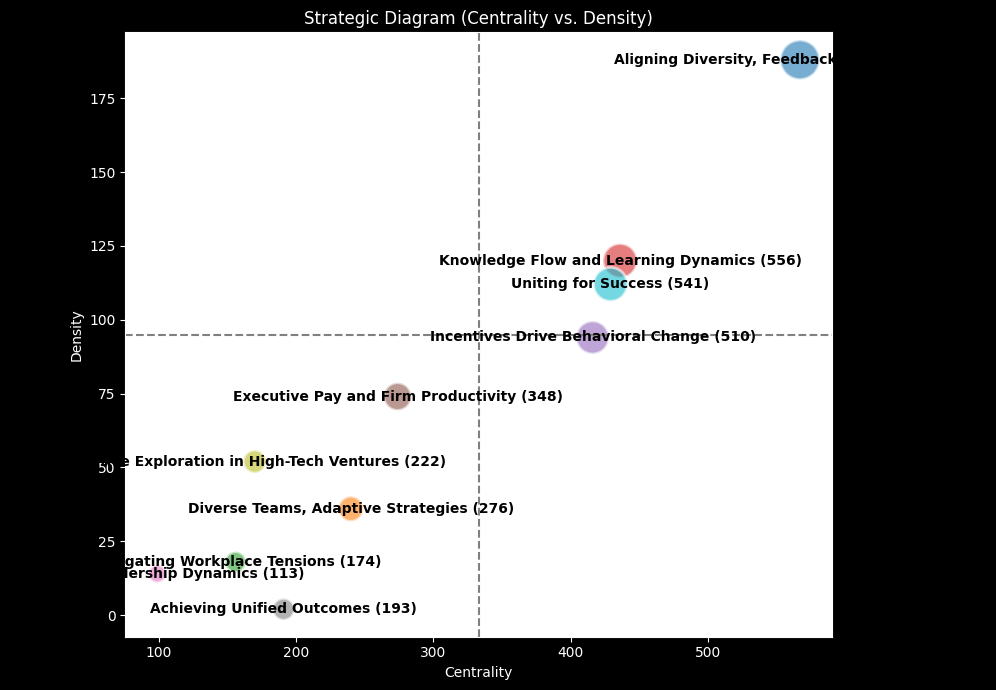

****** Last ran at =  2025-10-19 19:34:57.919202


In [26]:
#2. visualization-1   

# Add a bubble size column based on total co-occurrences for each cluster  
df5['BubbleSize'] = df5['Density'] + df5['Centrality']  # we just made it up for visualization purposes ... we will work out the bubblsize later  

# import matplotlib.pyplot as plt  
# import pandas as pd  
# import numpy as np  

# Example data  
# df5 = pd.DataFrame({  
#     'Cluster': ['A', 'B', 'C', 'D'],  
#     'Centrality': [10, 20, 15, 30],  
#     'Density': [5, 15, 10, 20],  
#     'BubbleSize': [100, 300, 200, 400]  
# })   

# Future Steps: Normalize BubbleSize for better visualization 

# Plotting function   
def plot_bubble_chart(df5):   
    fig, ax = plt.subplots(figsize=(10, 7))   
    colors = plt.cm.tab10(np.linspace(0, 1, len(df5)))   

    # Calculate axis midpoints for center lines   
    xmid = (df5['Centrality'].max() + df5['Centrality'].min()) / 2   
    ymid = (df5['Density'].max() + df5['Density'].min()) / 2    

    # Scatter plot   
    scaling_factor = 1     # Adjust this factor to scale bubble sizes appropriately    
    scatter = ax.scatter(   
        df5['Centrality'],   
        df5['Density'],    
        s=df5['BubbleSize'] * scaling_factor + 50,   # add 50 to ensure minimum size, should be in thousands.      
        c=colors,    
        alpha=0.6,  
        edgecolors='w',    
        linewidths=2    
    )    

    # Set white background   
    ax.set_facecolor('white')   

    # Draw middle lines   
    ax.axvline(x=xmid, color='grey', linestyle='--')   
    ax.axhline(y=ymid, color='grey', linestyle='--')   
   
    # Annotate bubbles   
    for i, row in df5.iterrows():   
        label = f"{row['Cluster']} ({row['BubbleSize']})"   
        ax.annotate(   
            label,   
            (row['Centrality'], row['Density']),   
            ha='center', va='center',    
            fontsize=10, color='black', weight='bold'   
        )    

    # Labels and title   
    ax.set_xlabel('Centrality')   
    ax.set_ylabel('Density')    
    ax.set_title('Strategic Diagram (Centrality vs. Density)')    

    # Aesthetics   
    plt.grid(False)    
    plt.tight_layout()   
    plt.show()    

# Call the plotting function with df5  
print(df5.head(15))  
print(f'We just made Bubble Size. We will work out the exact sizes later.')  
plot_bubble_chart(df5)   


print('****** Last ran at = ', datetime.now())    

## 5. Bubble Sizes  

1. Bubble size of a cluster = (1) #docs, or (2) sum(citations), or (3) average(citations).     

Plan 
1. Take `df3` (Keyword, DocIDs) and `df4` (Keyword, Cluster). 
2. Create `df6` => Cluster, DocIDs => Bubble Size is count(DocIDs) per cluster
3. Take `df6` (Cluster, DocIDs) and `df` (DocID, Citations) => Bubble Size is sum(citations) or average(citations) per cluster  
4. So, we should have `df6` columns as: 
    1. Cluster
    2. DocIDs (comma-separated or as list)
    3. BubbleSize1 (count of DocIDs)  
    3. BubbleSize2 (sum of citations per cluster)  
    4. BubbleSize3 (average citations per cluster)   

In [27]:
#1. all df's review  

print(f'{df.columns = } \n\t<-- this is an input data')   
print(f'{df2.columns = } \n\t<-- has exploded Keywords')   
print(f'{df3.columns = }')    
print(f'{df4.columns = } \n\t<-- this is an input data')   
print(f'{df5.columns = } \n\t<-- density, centrality, bubble size')   

print('****** Last ran at = ', datetime.now())  

df.columns = Index(['DocID', 'Title', 'Citations', 'Keywords'], dtype='object') 
	<-- this is an input data
df2.columns = Index(['DocID', 'Title', 'Citations', 'Keyword'], dtype='object') 
	<-- has exploded Keywords
df3.columns = Index(['Keyword', 'DocIDs'], dtype='object')
df4.columns = Index(['KWID', 'Keyword', 'ClusterID', 'Cluster'], dtype='object') 
	<-- this is an input data
df5.columns = Index(['Cluster', 'Density', 'Centrality', 'BubbleSize'], dtype='object') 
	<-- density, centrality, bubble size
****** Last ran at =  2025-10-19 19:34:57.937459


In [28]:
#2. bubble sizes 1,2,3    
# import pandas as pd    

# Step 1: Merge df3 and df4 on 'Keyword' to associate each keyword's docIDs with its cluster    
merged = pd.merge(df3, df4[['Keyword', 'Cluster']], on='Keyword', how='left')   
# merged.columns = 'Keyword', 'DocIDs', 'Cluster'    

# Step 2: Group by Cluster and gather DocIDs per cluster (flatten all DocIDs into one list per cluster)    

# Step 2.1: Function to flatten DocIDs (list)   
def flatten_docids(docid_series):    
    docid_list = []     
    for docids in docid_series:    
        # Assuming DocIDs are stored as a comma-separated string, adjust if already a list     
        if isinstance(docids, str):    
            docid_list.extend(docids.split(','))     
        elif isinstance(docids, list):    
            docid_list.extend(docids)     
    # Remove any leading/trailing whitespace and deduplicate
    docid_list = [d.strip() for d in docid_list if d.strip()]     
    return docid_list    

# Step 2.2: Group by Cluster and apply flattening function  
df6 = merged.groupby('Cluster')['DocIDs'].apply(flatten_docids).reset_index()   # Cluster, DocIDs (list)  

# Step 3: Compute BubbleSize1 (count of DocIDs per cluster)
df6['BubbleSize1'] = df6['DocIDs'].apply(len)   # Cluster, DocIDs, BubbleSize1   

# Step 4: Merge with citations info    

# Step 4.1: We'll need a mapping from DocID to Citations from df (DocID, Citations)     
docid_to_citations = dict(zip(df['DocID'].astype(str), df['Citations']))     

# STep 4.2: Functions to get sum and average citations per cluster    
def sum_citations(docids):     
    return sum(docid_to_citations.get(docid, 0) for docid in docids)     

def avg_citations(docids):     
    if len(docids) == 0:     
        return 0    
    return int(sum_citations(docids) / len(docids))     

# Step 5: Compute Bubble Sizes 2,3 (Sum, Average of Citations)   
df6['BubbleSize2'] = df6['DocIDs'].apply(sum_citations)     # Cluster, DocIDs, BubbleSize1, BubbleSize2      
df6['BubbleSize3'] = df6['DocIDs'].apply(avg_citations)     # Cluster, DocIDs, BubbleSize1, BubbleSize2, BubbleSize3    

# Step 6: Optional: If you want DocIDs as comma-separated string instead of list
# df6['DocIDs'] = df6['DocIDs'].apply(lambda x: ','.join(x))
# Final columns in df6: Cluster, DocIDs, BubbleSize1, BubbleSize2, BubbleSize3    

# Step 7: Print dataframes used (merged, df6)    
print(f'{merged.columns = }')    
print(f'{df6.columns = }')   
print(f'df6.head(15) = \n{df6.head(15)}')   # We know there are only 10 clusters, but show 15 for safety    

print('****** Last ran at = ', datetime.now())  

merged.columns = Index(['Keyword', 'DocIDs', 'Cluster'], dtype='object')
df6.columns = Index(['Cluster', 'DocIDs', 'BubbleSize1', 'BubbleSize2', 'BubbleSize3'], dtype='object')
df6.head(15) = 
                                      Cluster  \
0                  Achieving Unified Outcomes   
1    Aligning Diversity, Feedback, and Change   
2  Creative Exploration in High-Tech Ventures   
3          Diverse Teams, Adaptive Strategies   
4               Executive Leadership Dynamics   
5         Executive Pay and Firm Productivity   
6          Incentives Drive Behavioral Change   
7        Knowledge Flow and Learning Dynamics   
8               Navigating Workplace Tensions   
9                         Uniting for Success   

                                              DocIDs  BubbleSize1  \
0  [163, 57, 50, 61, 4, 42, 59, 180, 18, 193, 136...           46   
1  [78, 129, 24, 69, 5, 6, 82, 44, 29, 41, 119, 1...          170   
2  [67, 165, 46, 120, 143, 191, 11, 44, 56, 181, ...        

In [29]:
# save  

# Step 8: Save df6 (Bubble Sizes) to a file   
output6_file = input_file[0:-4]  +  '_out6_bs' + '.csv'   
df6.to_csv(output6_file, index=False)   
print("Done! Output-6 Bubble Sizes written to: ", output6_file)    

# Step 9: Update df5 and save again   
# Step 9.1: df6 (Bubble Sizes) -> df5   
df5["DocsCount"] = df6['BubbleSize1']   
df5["CitationsSum"] = df6['BubbleSize2']    
df5["CitationsAvg"] = df6['BubbleSize3']  
# Step 9.2:df4 Keyword counts -> df_test -> df5  
df_test = df4.groupby('Cluster')['Keyword'].count().reset_index()  
df5["KeywordsCount"] = df_test['Keyword']  
# Step 9.3: save output5 again   
df5.to_csv(output5_file, index=False)   
print("Done! Output-5 Updated df5 (Centrality, Density, Bubble Sizes): ", output5_file)    

print('****** Last ran at = ', datetime.now())    

Done! Output-6 Bubble Sizes written to:  2025-07-29_scopus_search8_194b_strategic_out6_bs.csv
Done! Output-5 Updated df5 (Centrality, Density, Bubble Sizes):  2025-07-29_scopus_search8_194b_strategic_out5_dc.csv
****** Last ran at =  2025-10-19 19:34:58.006808


In [30]:
#3. noramlize bubbleSize 
# Why? matplotlib typically expects bubble sizes in points^2, so we may need to scale our sizes accordingly.  

# Normalize function 
def normalize_bubble_size(df, col='BubbleSize', scaling_factor=1000, min_size=10, max_size=1000):
    """
    Normalizes a bubble size column and scales it for matplotlib bubble charts.
    
    Parameters:
        df (pd.DataFrame): Dataframe with bubble sizes.
        col (str): Name of the bubble size column.
        scaling_factor (float): Factor to scale normalized values.
        min_size (float): Minimum bubble size after normalization.
        max_size (float): Maximum bubble size after normalization.
        
    Returns:
        pd.Series: Normalized and scaled bubble sizes.
    """
    size = df[col]
    min_val, max_val = size.min(), size.max()
    
    # Avoid division by zero if all values are the same
    if min_val == max_val:
        norm = pd.Series([scaling_factor for _ in size], index=df.index)
    else:
        norm = ((size - min_val) / (max_val - min_val)) * (max_size - min_size) + min_size
        norm = norm * (scaling_factor / max_size)
    norm = list(map(int, norm))  # convert to int for matplotlib    
    return norm  

# Call the function  
df5['BubbleSize'] = normalize_bubble_size(df6, col='BubbleSize1', scaling_factor=5000, min_size=20, max_size=400)   

# print the comparison  
print('df6[BS1] \t df5[BS] \t df5[Cluster]')    
for item1, item2, item3 in zip(df6["BubbleSize1"], df5["BubbleSize"], df5["Cluster"]): 
    print(item1, '\t\t', item2, '\t\t', item3)     

print('****** Last ran at = ', datetime.now())   

df6[BS1] 	 df5[BS] 	 df5[Cluster]
46 		 937 		 Aligning Diversity, Feedback, and Change
170 		 5000 		 Diverse Teams, Adaptive Strategies
54 		 1200 		 Navigating Workplace Tensions
59 		 1363 		 Knowledge Flow and Learning Dynamics
25 		 250 		 Incentives Drive Behavioral Change
78 		 1986 		 Executive Pay and Firm Productivity
111 		 3067 		 Executive Leadership Dynamics
127 		 3591 		 Achieving Unified Outcomes
43 		 839 		 Creative Exploration in High-Tech Ventures
126 		 3558 		 Uniting for Success
****** Last ran at =  2025-10-19 19:34:58.020052


df6[BS1] 	 df5[BS] 	 df5[Cluster]
46 		 937 		 Aligning Diversity, Feedback, and Change
170 		 5000 		 Diverse Teams, Adaptive Strategies
54 		 1200 		 Navigating Workplace Tensions
59 		 1363 		 Knowledge Flow and Learning Dynamics
25 		 250 		 Incentives Drive Behavioral Change
78 		 1986 		 Executive Pay and Firm Productivity
111 		 3067 		 Executive Leadership Dynamics
127 		 3591 		 Achieving Unified Outcomes
43 		 839 		 Creative Exploration in High-Tech Ventures
126 		 3558 		 Uniting for Success


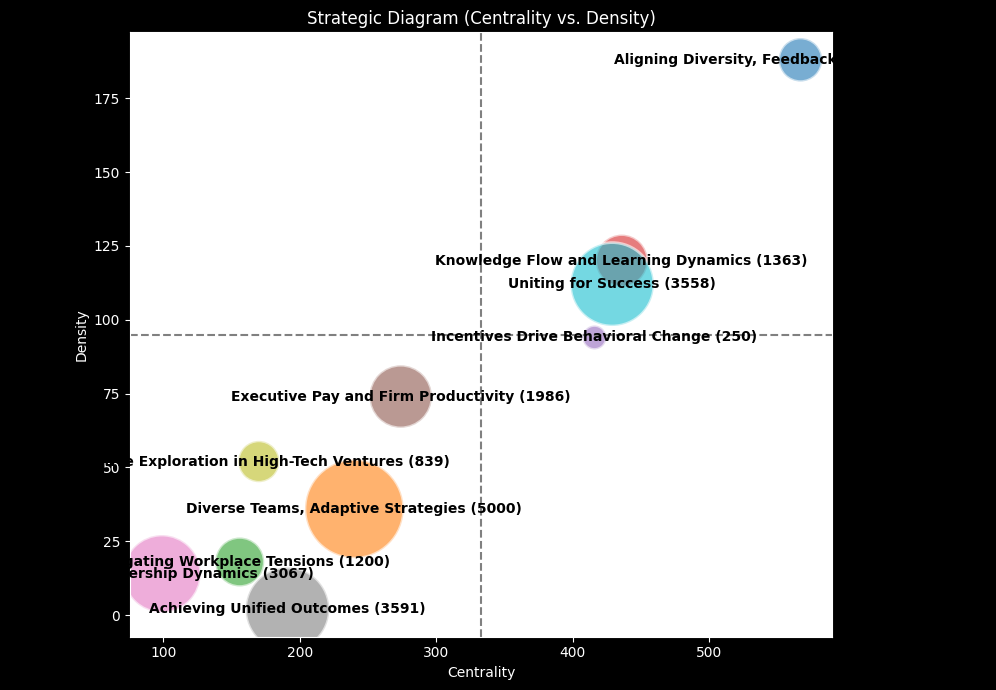

****** Last ran at =  2025-10-19 23:20:52.889598


In [34]:
#4. visualization-2 with BubbleSize1,2,3  

# Choose df6 column for bubble size  
bs_col = 'BubbleSize1'   # 1 = #docs, 2 = sum(citations), 3 = avg(citations)    

# Set BubbleSize in df5 using Noramlized BubbleSize1,2,3 from df6    
df5['BubbleSize'] = normalize_bubble_size(df6, col=bs_col, scaling_factor=5000, min_size=20, max_size=400)   

# Bubble Sizes 
print('df6[BS{}] \t df5[BS] \t df5[Cluster]'.format(bs_col[-1]))    
for item1, item2, item3 in zip(df6[bs_col], df5["BubbleSize"], df5["Cluster"]): 
    print(item1, '\t\t', item2, '\t\t', item3)  

# Call the plotting function with df5  
plot_bubble_chart(df5)   

print('****** Last ran at = ', datetime.now())    

In [32]:
#6. all df's review  

print(f'{df.columns = } \n\t<-- this is an input data')   
print(f'{df2.columns = } \n\t<-- has exploded Keywords')   
print(f'{df3.columns = } \n\t<-- this is an input data')    
print(f'{df4.columns = }')   
print(f'{df5.columns = } \n\t<-- bubble size is a normalized one from df6')   
print(f'{df6.columns = }')   

print('****** Last ran at = ', datetime.now())  

df.columns = Index(['DocID', 'Title', 'Citations', 'Keywords'], dtype='object') 
	<-- this is an input data
df2.columns = Index(['DocID', 'Title', 'Citations', 'Keyword'], dtype='object') 
	<-- has exploded Keywords
df3.columns = Index(['Keyword', 'DocIDs'], dtype='object') 
	<-- this is an input data
df4.columns = Index(['KWID', 'Keyword', 'ClusterID', 'Cluster'], dtype='object')
df5.columns = Index(['Cluster', 'Density', 'Centrality', 'BubbleSize', 'DocsCount',
       'CitationsSum', 'CitationsAvg', 'KeywordsCount'],
      dtype='object') 
	<-- bubble size is a normalized one from df6
df6.columns = Index(['Cluster', 'DocIDs', 'BubbleSize1', 'BubbleSize2', 'BubbleSize3'], dtype='object')
****** Last ran at =  2025-10-19 19:34:58.239391


In [33]:
# end    

end_time = datetime.now()      
total_duration = end_time - start_time      

print(f'{start_time = }, {end_time = }, {total_duration = }')      
print('****** Last ran at = ', datetime.now())      

start_time = datetime.datetime(2025, 10, 19, 19, 26, 8, 917254), end_time = datetime.datetime(2025, 10, 19, 19, 34, 58, 260692), total_duration = datetime.timedelta(seconds=529, microseconds=343438)
****** Last ran at =  2025-10-19 19:34:58.260692
